In [2]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from datetime import datetime

# === إعداد العشوائية ===
import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [8]:
# غيري المسار حسب مكان الملف عندك
data_path = "/content/Mental-Health-Twitter.csv"
df = pd.read_csv(data_path)

# تجميع كل البوستات لكل مستخدم
users = []
for user_id, group in df.groupby("user_id"):
    posts = []
    for _, row in group.iterrows():
        posts.append({
            "post_text": row["post_text"],
            "post_created": row["post_created"]
        })
    label = group["label"].iloc[0]
    users.append({
        "user_id": user_id,
        "posts": posts,
        "label": label
    })

print("Total users:", len(users))
print("Example user:", users[0])


Total users: 72
Example user: {'user_id': 14724376, 'posts': [{'post_text': "I was told when I was diagnosed with depression that I needed a family doctor. 2 years later, still can't find one.", 'post_created': 'Mon Mar 21 22:18:15 +0000 2016'}, {'post_text': '@jephjacques HELLO YES THIS IS DOG', 'post_created': 'Mon Mar 21 16:11:40 +0000 2016'}, {'post_text': 'RT @gpsforthebrain: Ah, spring. #Halifax #ohcanada https://t.co/32BPe0W2zD', 'post_created': 'Mon Mar 21 13:35:06 +0000 2016'}, {'post_text': '@AlexReekie Plus who wants to go out with a fish?', 'post_created': 'Mon Mar 21 10:35:42 +0000 2016'}, {'post_text': "@emastaflash @HfxGinger Hey it's totally a thing.", 'post_created': 'Mon Mar 21 10:35:18 +0000 2016'}, {'post_text': "@threehares Maybe Wednesday or Thursday, once I've recovered from the trauma of several days on the surgical floor :)", 'post_created': 'Mon Mar 21 02:07:28 +0000 2016'}, {'post_text': "@threehares I'm doing double shifts for the next 2 days, I doubt I'll b

In [9]:
class UserSequenceDataset(Dataset):
    def __init__(self, users, tokenizer, max_posts=10, max_len=64, use_time=True):
        self.users = users
        self.tokenizer = tokenizer
        self.max_posts = max_posts
        self.max_len = max_len
        self.use_time = use_time

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        label = user["label"]
        posts = sorted(user["posts"], key=lambda p: p["post_created"])

        texts = [p["post_text"] for p in posts[:self.max_posts]]
        if self.use_time:
            times = [datetime.strptime(p["post_created"], "%a %b %d %H:%M:%S %z %Y") for p in posts[:self.max_posts]]

        while len(texts) < self.max_posts:
            texts.append("")
            if self.use_time:
                times.append(times[0])

        encoded = self.tokenizer(texts, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        input_ids = encoded["input_ids"]
        attention_mask = encoded["attention_mask"]

        if self.use_time:
            base = times[0]
            time_deltas = [(t - base).days for t in times]
            time_deltas = torch.tensor(time_deltas, dtype=torch.float32).unsqueeze(-1)
        else:
            time_deltas = torch.zeros(self.max_posts, 1, dtype=torch.float32)

        return {"input_ids": input_ids, "attention_mask": attention_mask, "time_deltas": time_deltas, "labels": torch.tensor(label, dtype=torch.long)}


In [10]:
# === Time2Vec ===
class Time2Vec(nn.Module):
    def __init__(self, time_dim: int):
        super().__init__()
        self.time_dim = time_dim
        self.w0 = nn.Parameter(torch.randn(1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(time_dim))
        self.b = nn.Parameter(torch.randn(time_dim))

    def forward(self, t):
        v0 = self.w0 * t + self.b0
        v1 = torch.sin(self.w * t + self.b)
        return torch.cat([v0, v1], dim=-1)

# === Transformer + Time2Vec Model ===
class TimeEnrichedUserClassifier(nn.Module):
    def __init__(self, text_model_name="distilbert-base-uncased", hidden_dim=256, time_dim=8, num_labels=2, num_layers=2, num_heads=4):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_emb_dim = self.text_encoder.config.hidden_size
        self.time2vec = Time2Vec(time_dim=time_dim)
        time_emb_dim = time_dim + 1
        self.input_proj = nn.Linear(text_emb_dim + time_emb_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask, time_deltas):
        B, S, L = input_ids.shape
        flat_input_ids = input_ids.view(B * S, L)
        flat_attention_mask = attention_mask.view(B * S, L)
        text_outputs = self.text_encoder(input_ids=flat_input_ids, attention_mask=flat_attention_mask)
        cls_embs = text_outputs.last_hidden_state[:, 0, :]
        text_embs = cls_embs.view(B, S, -1)
        time_embs = self.time2vec(time_deltas)
        x = torch.cat([text_embs, time_embs], dim=-1)
        x = self.input_proj(x)
        x = self.transformer(x)
        user_repr = x.mean(dim=1)
        logits = self.classifier(user_repr)
        return logits

# === Transformer بدون وقت ===
class TransformerNoTime(nn.Module):
    def __init__(self, text_model_name="distilbert-base-uncased", hidden_dim=256, num_labels=2, num_layers=2, num_heads=4):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_emb_dim = self.text_encoder.config.hidden_size
        self.input_proj = nn.Linear(text_emb_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        B, S, L = input_ids.shape
        flat_input_ids = input_ids.view(B * S, L)
        flat_attention_mask = attention_mask.view(B * S, L)
        text_outputs = self.text_encoder(input_ids=flat_input_ids, attention_mask=flat_attention_mask)
        cls_embs = text_outputs.last_hidden_state[:, 0, :]
        text_embs = cls_embs.view(B, S, -1)
        x = self.input_proj(text_embs)
        x = self.transformer(x)
        user_repr = x.mean(dim=1)
        logits = self.classifier(user_repr)
        return logits


In [11]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

labels = [u["label"] for u in users]
train_users, test_users = train_test_split(users, test_size=0.2, random_state=42, stratify=labels)

train_dataset_time = UserSequenceDataset(train_users, tokenizer, use_time=True)
test_dataset_time  = UserSequenceDataset(test_users, tokenizer, use_time=True)
train_dataset_notime = UserSequenceDataset(train_users, tokenizer, use_time=False)
test_dataset_notime  = UserSequenceDataset(test_users, tokenizer, use_time=False)

train_loader_time = DataLoader(train_dataset_time, batch_size=4, shuffle=True)
test_loader_time  = DataLoader(test_dataset_time, batch_size=4)
train_loader_notime = DataLoader(train_dataset_notime, batch_size=4, shuffle=True)
test_loader_notime  = DataLoader(test_dataset_notime, batch_size=4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
def train_one_epoch(model, loader, optimizer, criterion, device, use_time=True):
    model.train()
    total_loss = 0.0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        if use_time:
            time_deltas = batch["time_deltas"].to(device)
            logits = model(input_ids, attention_mask, time_deltas)
        else:
            logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, use_time=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            if use_time:
                time_deltas = batch["time_deltas"].to(device)
                logits = model(input_ids, attention_mask, time_deltas)
            else:
                logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [16]:
model_time = TimeEnrichedUserClassifier(text_model_name=model_name).to(device)
model_notime = TransformerNoTime(text_model_name=model_name).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_time = torch.optim.AdamW(model_time.parameters(), lr=2e-5)
optimizer_notime = torch.optim.AdamW(model_notime.parameters(), lr=2e-5)

num_epochs = 8 # تقدرين ترفعينها مثلاً لـ 8 بعدين

# هنا بنخزن القيم لكل epoch
losses_time = []
accs_time = []
losses_notime = []
accs_notime = []

for epoch in range(1, num_epochs+1):
    # نموذج مع الزمن
    loss_time = train_one_epoch(
        model_time, train_loader_time, optimizer_time,
        criterion, device, use_time=True
    )
    acc_time = evaluate(
        model_time, test_loader_time, device, use_time=True
    )
    losses_time.append(loss_time)
    accs_time.append(acc_time)

    # نموذج بدون زمن
    loss_notime = train_one_epoch(
        model_notime, train_loader_notime, optimizer_notime,
        criterion, device, use_time=False
    )
    acc_notime = evaluate(
        model_notime, test_loader_notime, device, use_time=False
    )
    losses_notime.append(loss_notime)
    accs_notime.append(acc_notime)

    print(
        f"Epoch {epoch}: "
        f"Time2Vec -> Loss: {loss_time:.4f}, Acc: {acc_time:.4f} | "
        f"NoTime -> Loss: {loss_notime:.4f}, Acc: {acc_notime:.4f}"
    )


Epoch 1: Time2Vec -> Loss: 0.6164, Acc: 0.7333 | NoTime -> Loss: 0.6448, Acc: 0.7333
Epoch 2: Time2Vec -> Loss: 0.5377, Acc: 0.7333 | NoTime -> Loss: 0.5867, Acc: 0.7333
Epoch 3: Time2Vec -> Loss: 0.5019, Acc: 0.7333 | NoTime -> Loss: 0.4885, Acc: 0.7333
Epoch 4: Time2Vec -> Loss: 0.4995, Acc: 0.7333 | NoTime -> Loss: 0.4293, Acc: 0.7333
Epoch 5: Time2Vec -> Loss: 0.3316, Acc: 0.7333 | NoTime -> Loss: 0.3276, Acc: 0.7333
Epoch 6: Time2Vec -> Loss: 0.0802, Acc: 0.7333 | NoTime -> Loss: 0.3958, Acc: 0.5333
Epoch 7: Time2Vec -> Loss: 0.0126, Acc: 0.5333 | NoTime -> Loss: 0.2336, Acc: 0.7333
Epoch 8: Time2Vec -> Loss: 0.0061, Acc: 0.7333 | NoTime -> Loss: 0.0381, Acc: 0.6667


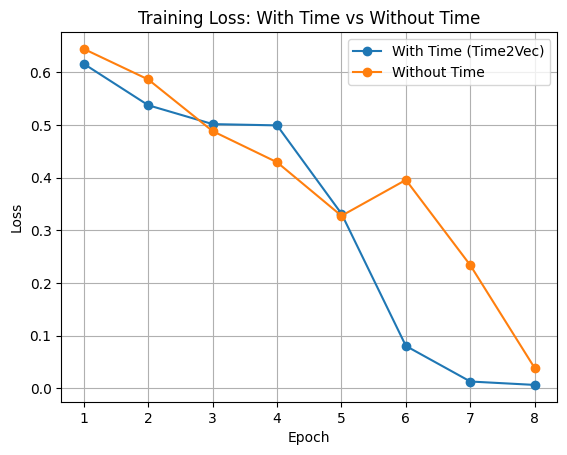

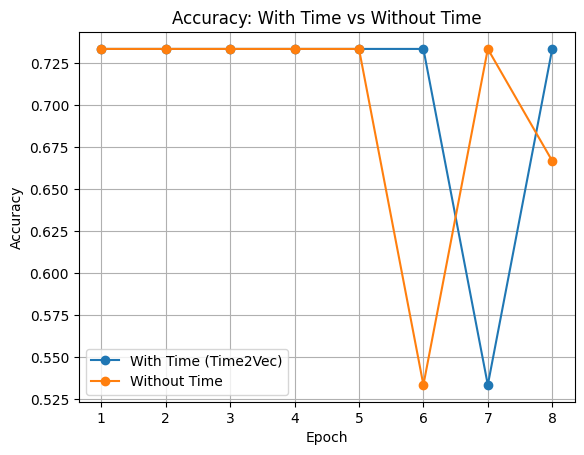

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# 🔹 رسم الـ Loss
plt.figure()
plt.plot(epochs, losses_time, marker='o', label='With Time (Time2Vec)')
plt.plot(epochs, losses_notime, marker='o', label='Without Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: With Time vs Without Time')
plt.legend()
plt.grid(True)
plt.show()

# 🔹 رسم الـ Accuracy
plt.figure()
plt.plot(epochs, accs_time, marker='o', label='With Time (Time2Vec)')
plt.plot(epochs, accs_notime, marker='o', label='Without Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy: With Time vs Without Time')
plt.legend()
plt.grid(True)
plt.show()
